In [1]:
import os
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns
from matplotlib import pyplot as plt
import tensorflow as tf

# EDA

In [2]:
train_path = './FER13/train'
test_path = './FER13/test'

train_images = 0
test_images = 0

train_label_count = {}
test_label_count = {}

labels = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

print(f"\nTraining dataset: ")
for label in os.listdir(train_path):
    if label != ".DS_Store":
        if label not in train_label_count:
            train_label_count[label] = len(os.listdir(os.path.join(train_path, label)))
        train_images += train_label_count[label]
        print(f"\t- {label.title()} : {len(os.listdir(os.path.join(train_path, label)))}")
        
print(f"\nTest dataset: ")
for label in os.listdir(test_path):
    if label != ".DS_Store":
        if label not in test_label_count:
            test_label_count[label] = len(os.listdir(os.path.join(train_path, label)))
        test_images += len(os.listdir(os.path.join(test_path, label)))
        print(f"\t- {label.title()} : {len(os.listdir(os.path.join(test_path, label)))}")

print(f"\nNumber of training images: {train_images}")
print(f"Number of test images: {test_images}")

print(f"\nTotal images: {train_images + test_images}")


Training dataset: 
	- Happy : 6834
	- Sad : 4685
	- Fear : 2535
	- Surprise : 3036
	- Neutral : 4295
	- Angry : 2832
	- Disgust : 2115

Test dataset: 
	- Happy : 1770
	- Sad : 1245
	- Fear : 1010
	- Surprise : 817
	- Neutral : 1233
	- Angry : 955
	- Disgust : 91

Number of training images: 26332
Number of test images: 7121

Total images: 33453


In [3]:
train_label_count

{'happy': 6834,
 'sad': 4685,
 'fear': 2535,
 'surprise': 3036,
 'neutral': 4295,
 'angry': 2832,
 'disgust': 2115}

In [4]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "./FER13/train",
    seed=123,
    image_size = (48,48),
    color_mode="grayscale"
)
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "./FER13/test",
    seed=123,
    image_size = (48,48),
    color_mode="grayscale"
)

Found 26332 files belonging to 7 classes.


2024-03-22 08:17:22.407509: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-03-22 08:17:22.407545: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-03-22 08:17:22.407554: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-03-22 08:17:22.407584: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-03-22 08:17:22.407627: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Found 7121 files belonging to 7 classes.


In [40]:
class_names = train_ds.class_names
class_names

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

2024-03-22 08:17:22.900839: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


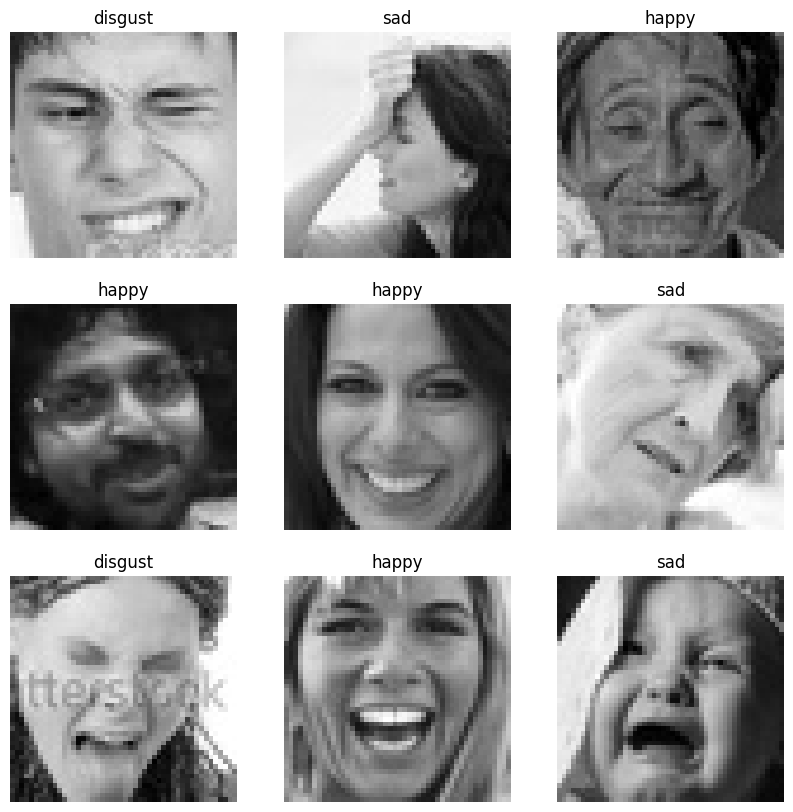

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
    for label in range(9):
        ax = plt.subplot(3, 3, label + 1)
        plt.imshow(images[label].numpy().astype("uint8"))
        plt.title(class_names[labels[label]])
        plt.axis("off")

In [7]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 48, 48, 3)
(32,)


In [8]:
import matplotlib.pyplot as plt

fig = px.bar(x=train_label_count.keys(), y=train_label_count.values(), labels={'x':'Emotion', 'y':'Count'}, color=train_label_count.keys())
fig.update_xaxes(categoryorder='total ascending')
fig.show()

In [9]:
# from keras.preprocessing.image import img_to_array, array_to_img, load_img
# from tensorflow.keras.preprocessing.image import ImageDataGenerator

# def augmented_data(folder_path, save_prefix="", save_format = "jpg", augment_params = None):
#     if augment_params is None:
#         augment_params = {
#             'rotation_range': 40,
#             'width_shift_range': 0.2,
#             'height_shift_range': 0.2,
#             'shear_range': 0.2,
#             'zoom_range': 0.2,
#             'horizontal_flip': True,
#             'fill_mode': 'nearest'
#         }

#     datagen = ImageDataGenerator(**augment_params)
#     for file in os.listdir(folder_path):
#         if file.endswith(('.jpg', '.jpeg', '.png')):
#             img = load_img(os.path.join(folder_path, file))
#             x = img_to_array(img)
#             x = x.reshape((1,) + x.shape)

#             i = 0
#             for batch in datagen.flow(x, batch_size=1, save_to_dir=folder_path, save_prefix=save_prefix, save_format=save_format):
#                 i += 1
#                 if i > 4:
#                     break

# disgust_path = "./FER13_cleaner/train/disgust"
# augmented_data(folder_path=disgust_path, save_prefix='augmented_image')

# Model

### VGG transfer learning

In [10]:
from keras.models import Model
from keras.layers import Flatten, Dense, Dropout
from keras.applications import VGG16

In [11]:
vgg = VGG16(input_shape=(48,48,3), weights="imagenet", include_top=False)
for layer in vgg.layers:
    layer.trainable = False

x = Flatten()(vgg.output)
x = Dense(128, activation="relu")(x)
x = Dense(64, activation="relu")(x)
x = Dense(len(class_names), activation="softmax")(x)

model = Model(inputs=vgg.input, outputs = x)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
metrics = tf.keras.metrics.SparseCategoricalAccuracy()
model.compile(
    optimizer='adam',
    loss=loss_fn,
    metrics=[metrics]
)

In [12]:
with tf.device("GPU:0"):
    model.fit(train_ds, validation_data=test_ds, epochs=20)

In [13]:
# model.save("./saved_model/vgg_transfer_learning.h5")

### VGG + SVM

In [14]:
from keras.models import Model
from keras.layers import Flatten, Dense, Dropout, Conv2D, BatchNormalization, MaxPooling2D
from keras.applications import VGG16

In [15]:
import tensorflow as tf

# Allow GPU memory growth
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)


Physical devices cannot be modified after being initialized


In [16]:
vgg = VGG16(input_shape=(48,48,3), weights="imagenet", include_top=False)
# for layer in vgg.layers:
#     layer.trainable = False
# visible = vgg.output
# visible = Flatten()(vgg.output)
# conv2_1 = Conv2D(128, kernel_size=3, activation='relu', padding='same', name = 'conv2_1')(visible)
# conv2_1 = BatchNormalization()(conv2_1)
# conv2_2 = Conv2D(128, kernel_size=3, activation='relu', padding='same', name = 'conv2_2')(conv2_1)
# conv2_2 = BatchNormalization()(conv2_2)
# conv2_3 = Conv2D(128, kernel_size=3, activation='relu', padding='same', name = 'conv2_3')(conv2_2)
# conv2_2 = BatchNormalization()(conv2_3)
# pool2_1 = MaxPooling2D(pool_size=(2,2), name = 'pool2_1')(conv2_3)
# drop2_1 = Dropout(0.3, name = 'drop2_1')(pool2_1)
# flatten = Flatten(name = 'flatten')(drop2_1)
# ouput = Dense(len(class_names), activation='softmax', name = 'output')(flatten)

x = Flatten()(vgg.output)
x = Dense(128, activation="relu")(x)
x = Dense(64, activation="relu")(x)
x = Dense(32, activation="relu")(x)
x = Dense(len(class_names), activation="softmax")(x)

model = Model(inputs=vgg.input, outputs = x)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
metrics = tf.keras.metrics.SparseCategoricalAccuracy()
model.compile(
    optimizer='AdamW',
    loss=loss_fn,
    metrics=[metrics]
)

In [17]:
callback = tf.keras.callbacks.EarlyStopping(monitor="loss", patience=3)
checkpoint = tf.keras.callbacks.ModelCheckpoint("./checkpoints/vgg_transferlearning.keras", monitor="accuracy")

In [18]:
with tf.device("GPU:0"):
    model.fit(train_ds, validation_data=test_ds, epochs=20, callbacks=[callback, checkpoint])

Epoch 1/20


2024-03-22 08:17:24.939826: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


823/823 ━━━━━━━━━━━━━━━━━━━━ 156s 184ms/step - loss: 3.5021 - sparse_categorical_accuracy: 0.2397 - val_loss: 1.8428 - val_sparse_categorical_accuracy: 0.2486
Epoch 2/20
823/823 ━━━━━━━━━━━━━━━━━━━━ 159s 193ms/step - loss: 1.8333 - sparse_categorical_accuracy: 0.2701 - val_loss: 1.7035 - val_sparse_categorical_accuracy: 0.3177
Epoch 3/20
823/823 ━━━━━━━━━━━━━━━━━━━━ 161s 196ms/step - loss: 1.6718 - sparse_categorical_accuracy: 0.3541 - val_loss: 1.5209 - val_sparse_categorical_accuracy: 0.4178
Epoch 4/20
823/823 ━━━━━━━━━━━━━━━━━━━━ 166s 201ms/step - loss: 1.5012 - sparse_categorical_accuracy: 0.4357 - val_loss: 1.4363 - val_sparse_categorical_accuracy: 0.4616
Epoch 5/20
823/823 ━━━━━━━━━━━━━━━━━━━━ 164s 200ms/step - loss: 1.3516 - sparse_categorical_accuracy: 0.4916 - val_loss: 1.4230 - val_sparse_categorical_accuracy: 0.4592
Epoch 6/20
823/823 ━━━━━━━━━━━━━━━━━━━━ 181s 220ms/step - loss: 1.2594 - sparse_categorical_accuracy: 0.5282 - val_loss: 1.2944 - val_sparse_categorical_accuracy

In [23]:
# model.save("./saved_model/vgg_gpus.h5")

In [47]:
from keras.models import load_model

model = load_model("./saved_model/vgg_gpus.h5")
model_tl = load_model("./saved_model/vgg.h5")

In [49]:
model_tl.evaluate(test_ds)

223/223 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 1.7468 - sparse_categorical_accuracy: 0.4132


[1.7975436449050903, 0.3988204002380371]

In [27]:
model.evaluate(test_ds)

223/223 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 1.2732 - sparse_categorical_accuracy: 0.5615


[1.3094593286514282, 0.5551186800003052]

In [51]:
from keras.preprocessing.image import load_img
import cv2

# img = load_img("./FER13/train/angry/Training_20655.jpg")
img = cv2.imread("./FER13/train/angry/Training_20655.jpg")
# print(img.shape)
# img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# img = cv2.resize(img, (48, 48, 3))
img = np.expand_dims(img, axis=0)
pred = model_tl.predict(img)

result = np.argmax(pred)
print(class_names[result])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step
fear


In [45]:
from keras.preprocessing.image import load_img
import cv2

# img = load_img("./FER13/train/angry/Training_20655.jpg")
img = cv2.imread("./FER13/train/angry/Training_20655.jpg")
# print(img.shape)
# img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# img = cv2.resize(img, (48, 48, 3))
img = np.expand_dims(img, axis=0)
pred = model.predict(img)

result = np.argmax(pred)
print(class_names[result])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
angry
